# Example adapted from Rosselini et.al 2024 for regression:

In [58]:
# importing the functions from our package
from Epistemic_CP.epistemic_cp import ECP_split, RegressionSplit
# quantile regression base model
from Epistemic_CP.utils import (average_coverage,
                                average_interval_score_loss)
from Epistemic_CP.scores import RegressionScore
# Define the random forest regressor
# base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing torch functions
import torch
from functools import partial
from sklearn.ensemble import RandomForestRegressor

In [59]:
def generate_data(n,  
                  cond_exp, 
                  noise_sd_fn, 
                  rng,):
    x = rng.uniform(size = n, 
                    low = -1, 
                    high = 1)
    noise_sd = noise_sd_fn(x)
    noise = rng.normal(scale=noise_sd, size=n)
    y = cond_exp(x)+noise
    return x.reshape(-1, 1),y

def cond_exp(x):
    return (x>-0)*1 # Generally we only make function of first covariate

def noise_sd_fn(x):
    return 0.01 + np.sin(15*x)**2*(x>0)

In [60]:
n_train = 200
n_calib = 200
n_test = 500
alpha = 0.1
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

# fixing random generator and torch seeds
rng = np.random.default_rng(450)
torch.manual_seed(25)
torch.cuda.manual_seed(25)

X_train, y_train = generate_data(n_train, 
                     cond_exp, 
                     noise_sd_fn,
                     rng,
                     )

X_calib, y_calib = generate_data(n_calib, 
                     cond_exp, 
                     noise_sd_fn,
                     rng,
                     )

X_test, y_test = generate_data(n_test, 
                     cond_exp, 
                     noise_sd_fn,
                     rng,
                     )

X_grid = np.linspace(-0.9999, 0.9999, 300).reshape(-1, 1)

In [61]:
# fitting base model
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Defining EPICSCORE object:

In [62]:
# defining ECP object
ecp_obj = ECP_split(
    RegressionScore,
    regressor,
    alpha=alpha,
    is_fitted=True,
    base_model_type="Quantile",
)

Fitting EPICSCORE-MC Dropout

Fitting MDN model:  21%|██        | 417/2000 [00:11<00:42, 36.98it/s]


Early stopping in epoch 417 with best validation loss: 0.4414


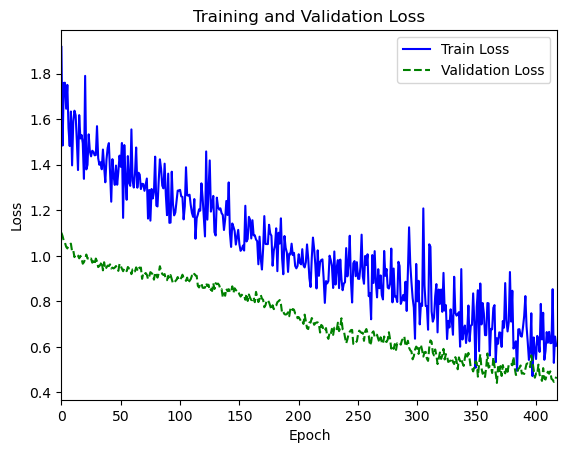

In [63]:
ecp_obj.fit(X_train, y_train)
ecp_obj.calib(
    X_calib,
    y_calib,
    num_components=3,
    dropout_rate=0.5,
    hidden_layers=[64, 64],
    patience=50,
    epochs=2000,
    scale=True,
    batch_size=15,
    normalize_y=True,
    verbose=2,
)

# predicting PI for MDN
pred_ecp_mdn = ecp_obj.predict(X_test)
grid_ecp_mdn = ecp_obj.predict(X_grid)

# computing marginal coverage
ecp_mdn_marginal_coverage = average_coverage(pred_ecp_mdn[:, 1], pred_ecp_mdn[:, 0], y_test)
ecp_mdn_aisl = average_interval_score_loss(pred_ecp_mdn[:, 1], pred_ecp_mdn[:, 0], y_test, alpha = alpha)

Fitting EPISCORE-Variational GP:

Fitting GP model:  38%|███▊      | 189/500 [00:19<00:31,  9.77it/s]

Early stopping in epoch 189 with best validation loss:  1.0777


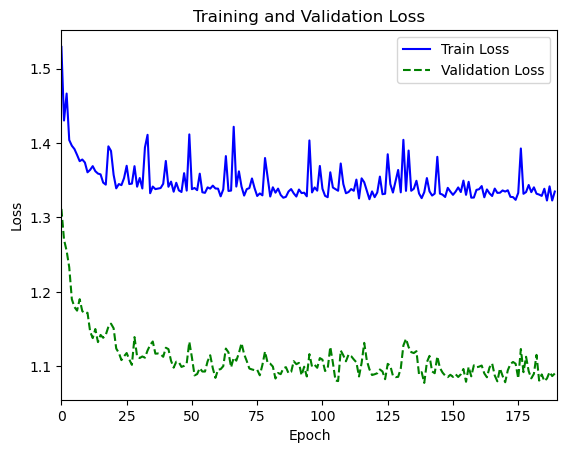

In [64]:
ecp_obj.calib(
    X_calib,
    y_calib,
    epistemic_model="GP_variational",
    scale=True,
    normalize_y=True,
    num_inducing_points=5,
    patience=50,
    n_epoch=500,
    batch_size=15,
    verbose=2,
)

pred_ecp_gp = ecp_obj.predict(X_test)
grid_ecp_gp = ecp_obj.predict(X_grid)

# computing marginal coverage
ecp_gp_marginal_coverage = average_coverage(pred_ecp_gp[:, 1], pred_ecp_gp[:, 0], y_test)
ecp_gp_aisl = average_interval_score_loss(pred_ecp_gp[:, 1], pred_ecp_gp[:, 0], y_test, alpha = alpha)

Fitting EPISCORE-BART:

In [65]:
ecp_obj.fit(X_train, y_train)
ecp_obj.calib(
    X_calib,
    y_calib,
    epistemic_model="BART",
    m=100,
    var="heteroscedastic",
    type = "normal",
    normalize_y = "True",
    progress = False,
)
# predicting PI for BART
pred_ecp_bart = ecp_obj.predict(X_test)
grid_ecp_bart = ecp_obj.predict(X_grid)

# computing marginal coverage
ecp_bart_marginal_coverage = average_coverage(pred_ecp_bart[:, 1], pred_ecp_bart[:, 0], y_test)
ecp_bart_aisl = average_interval_score_loss(pred_ecp_bart[:, 1], pred_ecp_bart[:, 0], y_test, alpha = alpha)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [w]
Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 69 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [w, y_pred]
Sampling: [w, y_pred]
Sampling: [w, y_pred]


In [69]:
reg_split_obj = RegressionSplit(regressor,
                        alpha = alpha,
                        is_fitted = True)
reg_split_obj.fit(X_train, y_train)
reg_split_obj.calibrate(X_calib, y_calib)

pred_reg_split = reg_split_obj.predict(X_test)
grid_reg_split = reg_split_obj.predict(X_grid)

# computing marginal coverage
reg_split_marginal_coverage = average_coverage(pred_reg_split[:, 1], pred_reg_split[:, 0], y_test)
reg_split_aisl = average_interval_score_loss(pred_reg_split[:, 1], pred_reg_split[:, 0], y_test, alpha = alpha)

In [70]:
print("EPICSCORE-MC Dropout:")
print(f"Marginal Coverage: {ecp_mdn_marginal_coverage}")
print(f"AISL: {ecp_mdn_aisl}\n")

print("EPICSCORE-Variational GP:")
print(f"Marginal Coverage: {ecp_gp_marginal_coverage}")
print(f"AISL: {ecp_gp_aisl}\n")

print("EPICSCORE-BART:")
print(f"Marginal Coverage: {ecp_bart_marginal_coverage}")
print(f"AISL: {ecp_bart_aisl}\n")

print("Reg-Split:")
print(f"Marginal Coverage: {reg_split_marginal_coverage}")
print(f"AISL: {reg_split_aisl}")

EPICSCORE-MC Dropout:
Marginal Coverage: 0.866
AISL: 2.1955770352375077

EPICSCORE-Variational GP:
Marginal Coverage: 0.878
AISL: 2.2884957484814032

EPICSCORE-BART:
Marginal Coverage: 0.9
AISL: 1.769627197674419

Reg-Split:
Marginal Coverage: 0.896
AISL: 2.5852696821372065


/tmp/ipykernel_63660/311763403.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 0].legend()
/tmp/ipykernel_63660/311763403.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0, 1].legend()
/tmp/ipykernel_63660/311763403.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 0].legend()
/tmp/ipykernel_63660/311763403.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1, 1].legend()


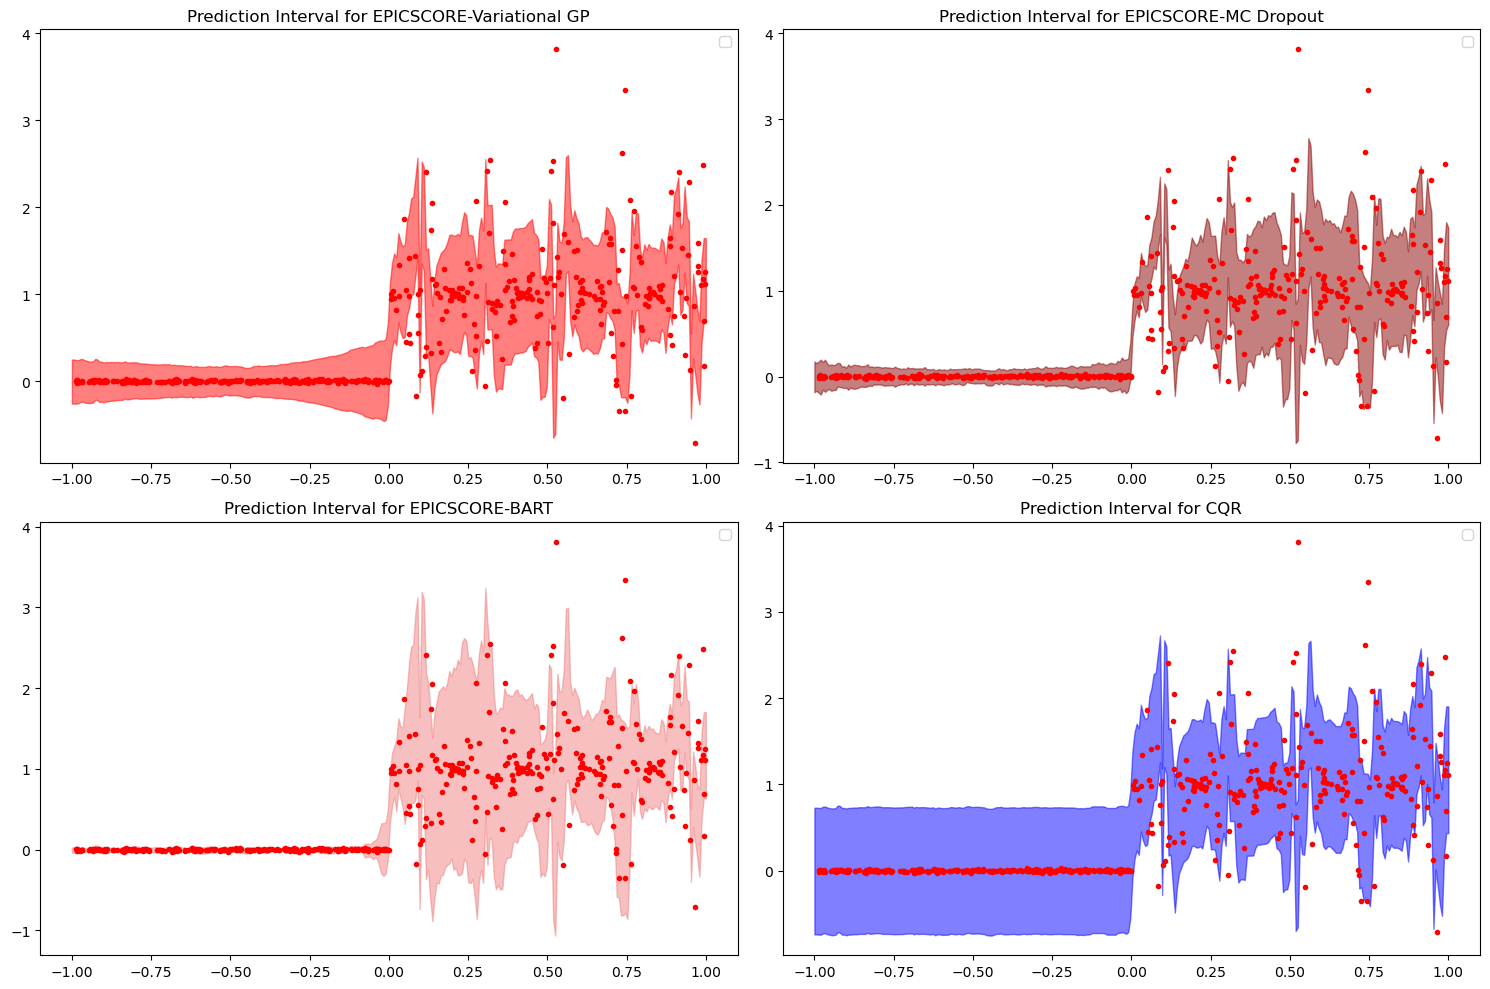

In [ ]:
# Adjusting the layout to have 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot for grid_ecp_gp
axs[0, 0].fill_between(X_grid.flatten(), grid_ecp_gp[:, 0], grid_ecp_gp[:, 1], color='red', alpha=0.5)
axs[0, 0].plot(X_test.flatten(), y_test, 'r.')
axs[0, 0].set_title('Prediction Interval for EPICSCORE-Variational GP')
axs[0, 0].legend()

# Plot for grid_ecp_mdn
axs[0, 1].fill_between(X_grid.flatten(),
                       grid_ecp_mdn[:, 0], 
                       grid_ecp_mdn[:, 1], 
                       color='darkred',
                       alpha=0.5)
axs[0, 1].plot(X_test.flatten(), y_test, 'r.')
axs[0, 1].set_title('Prediction Interval for EPICSCORE-MC Dropout')
axs[0, 1].legend()

# Plot for grid_ecp_bart
axs[1, 0].fill_between(X_grid.flatten(), grid_ecp_bart[:, 0], grid_ecp_bart[:, 1], color='lightcoral', alpha=0.5)
axs[1, 0].plot(X_test.flatten(), y_test, 'r.')
axs[1, 0].set_title('Prediction Interval for EPICSCORE-BART')
axs[1, 0].legend()

# Plot for grid_cqr
axs[1, 1].fill_between(X_grid.flatten(), grid_reg_split[:, 0], grid_reg_split[:, 1], color='blue', alpha=0.5)
axs[1, 1].plot(X_test.flatten(), y_test, 'r.')
axs[1, 1].set_title('Prediction Interval for Regression-split')
axs[1, 1].legend()

plt.tight_layout()
plt.show()